# Attrition Project DT Classification

### KDD Process
1. Libraries and Attrition Dataset load
1. Data Cleaning: handle missing values, outliers and dimensionality reduction
1. Classification Preprocessing: feature reshaping and training/test partitioning
1. Parameter Tuning
1. Perform Classification
1. Analyze the classification results
1. Analyze the classification performance
1. Can we improve the performance using another classifier?

### Libraries & Attrition dataset load

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from statistics import mean
import matplotlib.pyplot as plt



In [27]:
df_train = pd.read_csv("./Dataset/Train_HR_Employee_Attrition.csv")
df_test = pd.read_csv("./Dataset/Test_HR_Employee_Attrition.csv")

### Data Cleaning: missing values, outliers and dimensionality reduction
This section has been replied from data understanding section for both training/test set.  

In [2]:
#SETTING TRAINING SET (as executed in DataUnderstanding-attrition)


#MISSING VALUES

#infer Gender by Gender mode
df_train['Gender']=df_train['Gender'].fillna(df_train['Gender'].mode()[0])

#infer BusinessTravel by BusinessTravel mode
df_train['BusinessTravel']=df_train['BusinessTravel'].fillna(df_train['BusinessTravel'].mode()[0])

#infer PerformanceRating by PerformanceRating mode
df_train['PerformanceRating'] = df_train['PerformanceRating'].fillna(df_train['PerformanceRating'].mode()[0])

#infer YearsAtCompany by YearsAtCompany mean
df_train['YearsAtCompany'] = df_train['YearsAtCompany'].fillna(df_train['YearsAtCompany'].median())

#infer MonthlyIncome by mean grouped by YearsAtCompany-Quartiles
bins = pd.qcut(df_train['YearsAtCompany'],[0,0.25,0.50,0.75,1.0])
df_train['MonthlyIncome'] = df_train['MonthlyIncome'].groupby(bins).apply(
                      lambda x: x.fillna(x.mean()))

#infer Age by mean grouped by MonthlyIncome-quartiles
bins = pd.qcut(df_train['MonthlyIncome'],[0,0.25,0.50,0.75,1.0])
df_train['Age'] = df_train['Age'].groupby(bins).apply(lambda x: x.fillna(x.mean()))

#TrainingTimesLastYear by fillna with TrainingTimesLastYear values probability
df_train['TrainingTimesLastYear'] = df_train['TrainingTimesLastYear'].fillna(df_train['TrainingTimesLastYear'].mode()[0])


#OUTLIERS
df_train["MonthlyIncomeTrans"] = np.log(df_train['MonthlyIncome'])


#DIENSIONALITY REDUCTION
df_train['YearsMean'] = None
for index, row in df_train.iterrows(): 
    df_train.loc[index, 'YearsMean'] = mean((row['YearsInCurrentRole'], row['YearsSinceLastPromotion'], row['YearsWithCurrManager']))

df_train = df_train.drop(columns = ['MonthlyIncome','YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager','Over18','StandardHours'], axis = 'columns')

In [3]:
#SETTING TEST SET (how we did before for traing set )


#MISSING VALUES

#infer Gender by Gender mode
df_test['Gender']=df_test['Gender'].fillna(df_test['Gender'].mode()[0])

#infer BusinessTravel by BusinessTravel mode
df_test['BusinessTravel']=df_test['BusinessTravel'].fillna(df_test['BusinessTravel'].mode()[0])

#infer PerformanceRating by PerformanceRating mode
df_test['PerformanceRating'] = df_test['PerformanceRating'].fillna(df_test['PerformanceRating'].mode()[0])

#infer YearsAtCompany by YearsAtCompany mean
df_test['YearsAtCompany'] = df_test['YearsAtCompany'].fillna(df_test['YearsAtCompany'].median())

#infer MonthlyIncome by mean grouped by YearsAtCompany-Quartiles
bins = pd.qcut(df_test['YearsAtCompany'],[0,0.25,0.50,0.75,1.0])
df_test['MonthlyIncome'] = df_test['MonthlyIncome'].groupby(bins).apply(
                      lambda x: x.fillna(x.mean()))

#infer Age by mean grouped by MonthlyIncome-quartiles
bins = pd.qcut(df_test['MonthlyIncome'],[0,0.25,0.50,0.75,1.0])
df_test['Age'] = df_test['Age'].groupby(bins).apply(lambda x: x.fillna(x.mean()))

#TrainingTimesLastYear by fillna with TrainingTimesLastYear values probability
df_test['TrainingTimesLastYear'] = df_test['TrainingTimesLastYear'].fillna(df_test['TrainingTimesLastYear'].mode()[0])


#OUTLIERS
df_test["MonthlyIncomeTrans"] = np.log(df_test['MonthlyIncome'])


#DIENSIONALITY REDUCTION
df_test['YearsMean'] = None
for index, row in df_test.iterrows(): 
    df_test.loc[index, 'YearsMean'] = mean((row['YearsInCurrentRole'], row['YearsSinceLastPromotion'], row['YearsWithCurrManager']))

df_test = df_test.drop(columns = ['MonthlyIncome','YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager','Over18','StandardHours'], axis = 'columns')

### Classification Preprocessing
Nominal features have been reshaped for both sets 

In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoders = dict()
column2encode = ['Attrition', 'BusinessTravel','Department','EducationField', 'Gender', 'JobRole', 
                 'MaritalStatus', 'OverTime', 'YearsMean']

for col in column2encode:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    label_encoders[col] = le
    
for col in column2encode:
    le = LabelEncoder()
    df_test[col] = le.fit_transform(df_test[col])
    label_encoders[col] = le


Partitioning training and test set.

In [5]:
from sklearn.model_selection import train_test_split

attributes = [col for col in df_train.columns if col != 'Attrition']

# Training split
X_train = df_train[attributes].values
y_train = df_train['Attrition']

# Test split
X_test = df_test[attributes].values
y_test = df_test['Attrition']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1176, 28), (294, 28), (1176,), (294,))

### Parameter Tuning

In [86]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

In [87]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [88]:
param_list = {'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
             }

clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1)

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=100)
random_search.fit(X_train, y_train)
report(random_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.850 (std: 0.020)
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 2}

Model with rank: 1
Mean validation score: 0.850 (std: 0.020)
Parameters: {'min_samples_split': 30, 'min_samples_leaf': 1, 'max_depth': 2}

Model with rank: 1
Mean validation score: 0.850 (std: 0.020)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 2}



### Perform Classification

In [91]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=10, min_samples_leaf=10)
clf = clf.fit(X_train, y_train)

In [92]:
y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

### Analyze the classification results

Features importances

In [93]:
for col, imp in zip(attributes, clf.feature_importances_):
    print(col, imp)

Age 0.040702194275961646
BusinessTravel 0.0
DailyRate 0.043356369757384175
Department 0.0
DistanceFromHome 0.06449041215016119
Education 0.0
EducationField 0.0
EnvironmentSatisfaction 0.035921690016753154
Gender 0.0
HourlyRate 0.06102401929831035
JobInvolvement 0.0
JobLevel 0.2502763424518589
JobRole 0.049131089919348
JobSatisfaction 0.017928253851782937
MaritalStatus 0.0
MonthlyRate 0.0
NumCompaniesWorked 0.054615643821916075
OverTime 0.17035464664078775
PercentSalaryHike 0.0
PerformanceRating 0.0
RelationshipSatisfaction 0.004980980199503262
StockOptionLevel 0.04129894220071388
TotalWorkingYears 0.06893175441358362
TrainingTimesLastYear 0.0
WorkLifeBalance 0.037729178847135954
YearsAtCompany 0.0
MonthlyIncomeTrans 0.023784533901172276
YearsMean 0.03547394825362695


Visualize the decision tree

In [94]:
import pydotplus
from sklearn import tree
from IPython.display import Image

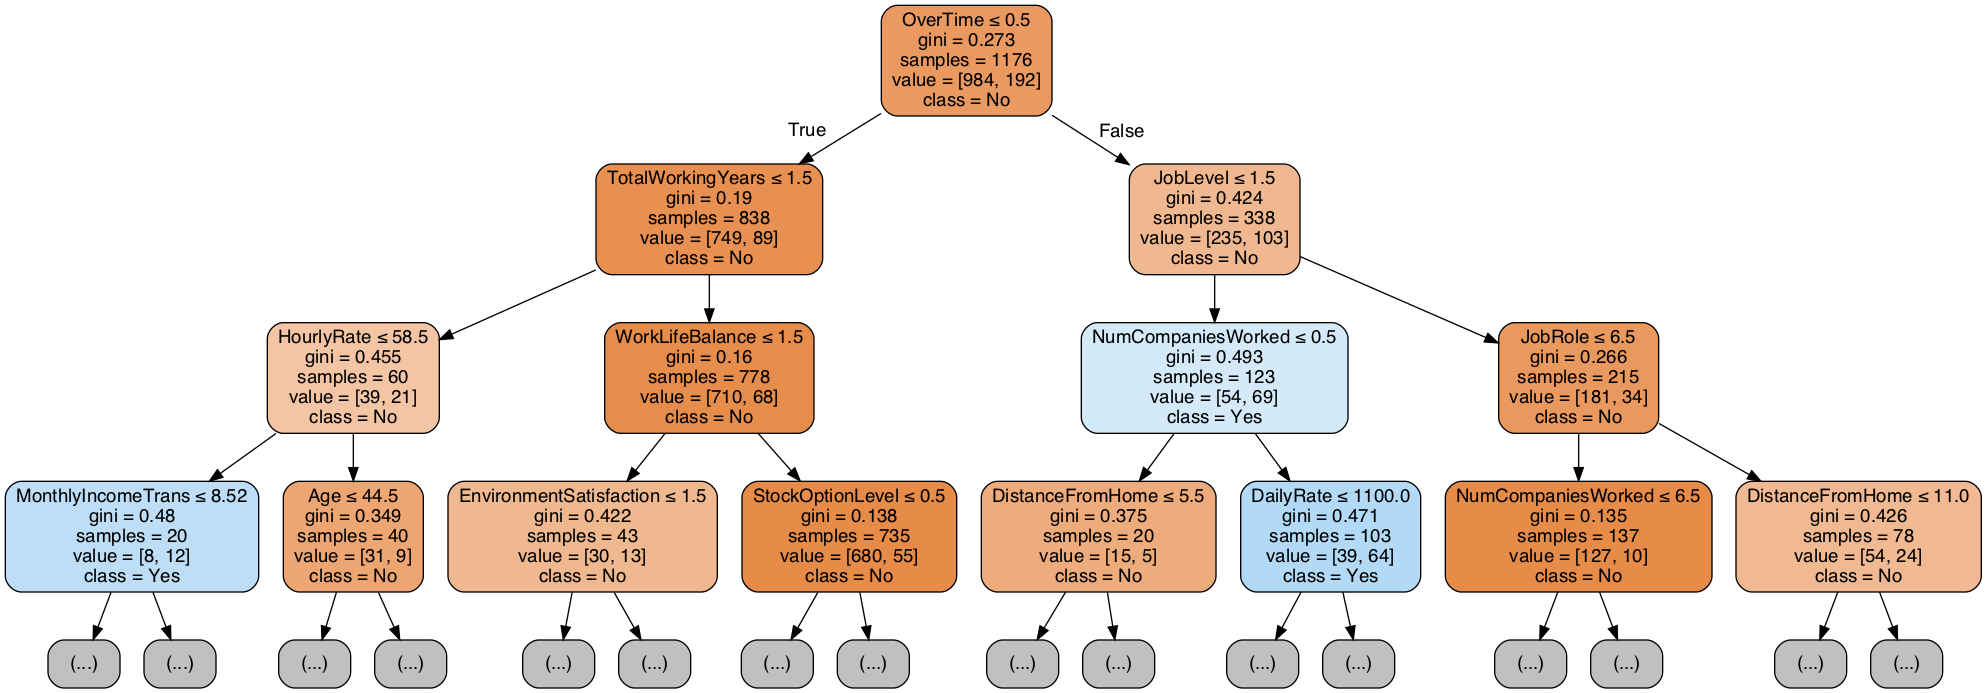

In [95]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=attributes,
                                class_names=['Yes' if x == 1 else 'No' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### Analyze the classification performance

In [96]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

Assess the performances

In [97]:
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print()

print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Train Accuracy 0.8809523809523809
Train F1-score [0.93110236 0.5625    ]

Test Accuracy 0.826530612244898
Test F1-score [0.90019569 0.33766234]

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       249
           1       0.41      0.29      0.34        45

    accuracy                           0.83       294
   macro avg       0.64      0.61      0.62       294
weighted avg       0.81      0.83      0.81       294



array([[230,  19],
       [ 32,  13]])

In [98]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)

0.6062918340026773


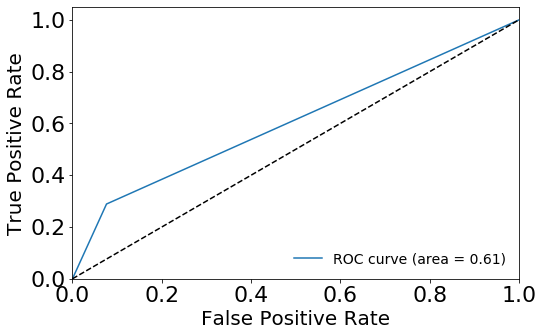

In [99]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

### Can we improve the performance using another classifier?

In [100]:
from sklearn.ensemble import RandomForestClassifier

In [103]:
param_list = {'max_depth': [None] + list(np.arange(2, 50)),
              'min_samples_split': [2, 5, 10, 15, 20, 30, 50, 100, 150],
              'min_samples_leaf': [1, 5, 10, 15, 20, 30, 50, 100, 150],
              'criterion': ['gini', 'entropy'],
             }

clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, 
                             min_samples_split=2, min_samples_leaf=1, class_weight=None)

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=100)
random_search.fit(X_train, y_train)
report(random_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.856 (std: 0.011)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 14, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.852 (std: 0.013)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 17, 'criterion': 'gini'}

Model with rank: 3
Mean validation score: 0.851 (std: 0.008)
Parameters: {'min_samples_split': 15, 'min_samples_leaf': 5, 'max_depth': 22, 'criterion': 'entropy'}



In [104]:
clf = random_search.best_estimator_

y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

In [106]:
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print()

print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Train Accuracy 0.9914965986394558
Train F1-score [0.99494439 0.97326203]

Test Accuracy 0.8605442176870748
Test F1-score [0.92307692 0.25454545]

              precision    recall  f1-score   support

           0       0.87      0.99      0.92       249
           1       0.70      0.16      0.25        45

    accuracy                           0.86       294
   macro avg       0.78      0.57      0.59       294
weighted avg       0.84      0.86      0.82       294



array([[246,   3],
       [ 38,   7]])

In [107]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)
roc_auc

0.5717536813922355


0.5717536813922355

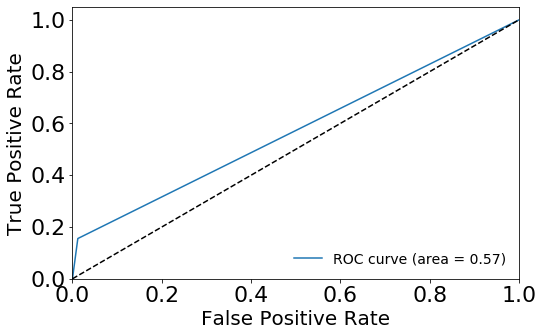

In [108]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [109]:
scores = cross_val_score(clf, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X, y, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

NameError: name 'cross_val_score' is not defined

In [6]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='gini', max_depth=None, 
                             min_samples_split=2, min_samples_leaf=1)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [7]:
for col, imp in zip(attributes, clf.feature_importances_):
    print(col, imp)

Age 0.06181208204894869
BusinessTravel 0.0153539972899729
DailyRate 0.08728558669166868
Department 0.015134305754822254
DistanceFromHome 0.06959141335833967
Education 0.011047088097896392
EducationField 0.018051602200040314
EnvironmentSatisfaction 0.010266302327729942
Gender 0.0031122967479674797
HourlyRate 0.04334425058976719
JobInvolvement 0.0216163386226692
JobLevel 0.0790304722359361
JobRole 0.032188191745537685
JobSatisfaction 0.027830129369030607
MaritalStatus 0.012233616654348363
MonthlyRate 0.020929203856827068
NumCompaniesWorked 0.051761921683329534
OverTime 0.05908945910980497
PercentSalaryHike 0.02796153261330473
PerformanceRating 0.01201997482597374
RelationshipSatisfaction 0.0393228882509218
StockOptionLevel 0.03689331358440668
TotalWorkingYears 0.05959032740992843
TrainingTimesLastYear 0.02099352294348366
WorkLifeBalance 0.03816823686744524
YearsAtCompany 0.03765977509536095
MonthlyIncomeTrans 0.040063823694863616
YearsMean 0.04764834632967402


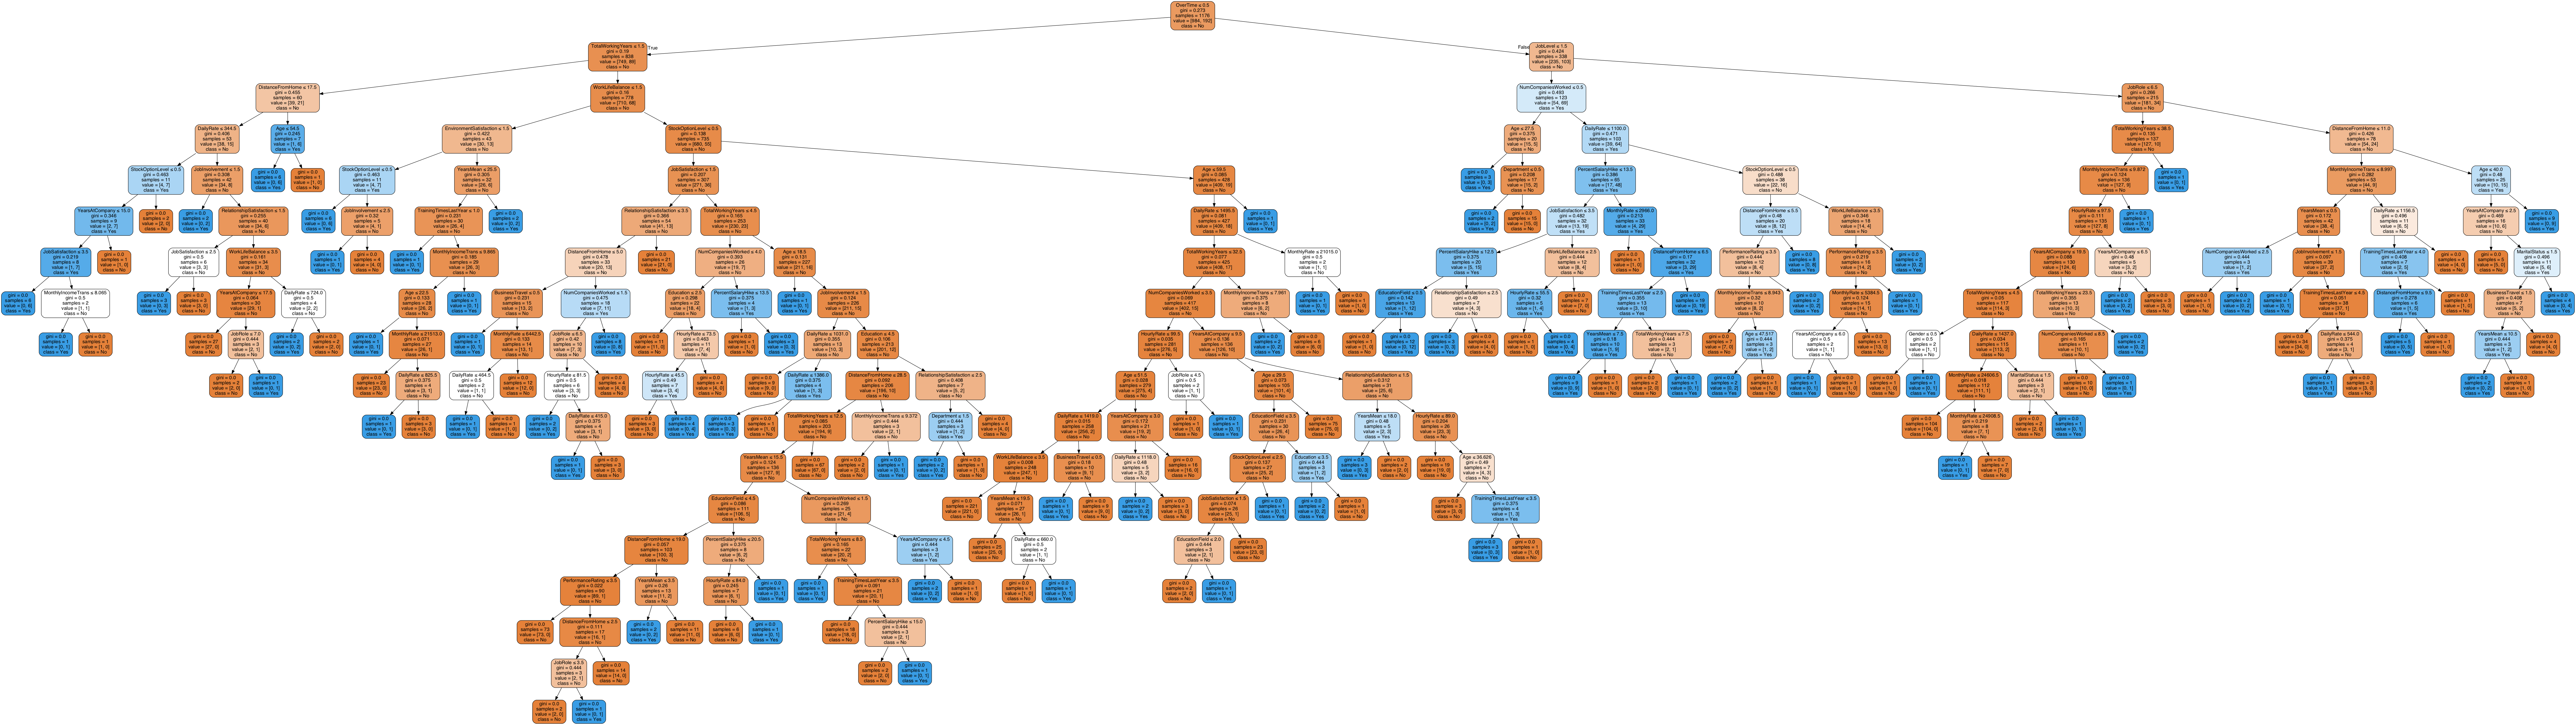

In [13]:
#conda install graphviz
#conda install -c conda-forge pydotplus
import pydotplus
from sklearn import tree
from IPython.display import Image


dot_data = tree.export_graphviz(clf, out_file=None,  
                                feature_names=attributes, 
                                class_names=['Yes' if x == 1 else 'No' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [17]:
y_pred = clf.predict(X_train)

In [18]:
print('Accuracy %s' % accuracy_score(y_train, y_pred))
print('F1-score %s' % f1_score(y_train, y_pred, average=None))

Accuracy 1.0
F1-score [1. 1.]


In [22]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       984
           1       1.00      1.00      1.00       192

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176



In [23]:
y_pred = clf.predict(X_test)

In [24]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Accuracy 0.7551020408163265
F1-score [0.85185185 0.29411765]
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       249
           1       0.26      0.33      0.29        45

    accuracy                           0.76       294
   macro avg       0.57      0.58      0.57       294
weighted avg       0.78      0.76      0.77       294



array([[207,  42],
       [ 30,  15]])

# Ciao